In [1]:
import re
import os
import gc
import time
import random
import string

import copy
from copy import deepcopy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Pytorch Import
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

## torchinfo
from torchinfo import summary

## sklearn
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GroupKFold, train_test_split

# Utils
from tqdm.auto import tqdm, trange

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
# import warnings
# warnings.filterwarnings("ignore")

from datetime import datetime, timedelta

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
home_path = '/kaggle/input/predict-energy-behavior-of-prosumers/'

client = pd.read_csv(home_path + 'client.csv')
gas_prices = pd.read_csv(home_path + 'gas_prices.csv')
electricity_prices = pd.read_csv(home_path + 'electricity_prices.csv')
historical_weather = pd.read_csv(home_path + 'historical_weather.csv')
train = pd.read_csv(home_path + 'train.csv')
forecast_weather = pd.read_csv(home_path + 'forecast_weather.csv')

In [3]:
train000 = pd.read_csv(home_path + 'train.csv')

In [4]:
train['new_datetime'] = train['datetime']

In [5]:
# for dirname, _, filenames in os.walk('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#         [name, types] = filename.split('.')
#         globals()[f't_{name}'] = pd.read_csv(os.path.join(dirname, filename))
#         print(f't_{name}')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
 9   new_datetime        object 
dtypes: float64(1), int64(7), object(2)
memory usage: 154.0+ MB


In [7]:
# 1. make revealed target column
def make_revealed_target_col(tr):
    tr['revealed_target']=tr.groupby(['is_consumption','prediction_unit_id']).target.shift(48)
    tr['revealed_target']=tr.revealed_target.fillna(0)
    return tr

In [8]:
train=make_revealed_target_col(train)

In [9]:
#drop data_block_id==0,1
train=train[(train.data_block_id!=0)&(train.data_block_id!=1)]
#drop data_block_id
data_names=['client','gas_prices','electricity_prices','historical_weather','forecast_weather','train']
for name in data_names:
    globals()[name]=globals()[name].drop(columns='data_block_id')

In [10]:
train

,county,is_business,product_type,target,is_consumption,datetime,row_id,prediction_unit_id,new_datetime,revealed_target
5856,0,0,1,0.793,0,2021-09-03 00:00:00,5856,0,2021-09-03 00:00:00,0.713
5857,0,0,1,107.129,1,2021-09-03 00:00:00,5857,0,2021-09-03 00:00:00,96.590
5858,0,0,2,0.000,0,2021-09-03 00:00:00,5858,1,2021-09-03 00:00:00,0.000
5859,0,0,2,19.630,1,2021-09-03 00:00:00,5859,1,2021-09-03 00:00:00,17.314
5860,0,0,3,0.977,0,2021-09-03 00:00:00,5860,2,2021-09-03 00:00:00,2.904
...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,2018347,64,2023-05-31 23:00:00,188.167
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,2018348,59,2023-05-31 23:00:00,0.000
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,2018349,59,2023-05-31 23:00:00,31.484
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,2018350,60,2023-05-31 23:00:00,0.000


In [11]:
# make counties_info
def make_counties_info():
    # Coordinates of counties
    counties_dict = {
        0:{"name": "HARJUMAA","coords": (59.351142, 24.725384)},
        1:{"name": "HIIUMAA","coords": (58.918082, 22.586403)},
        2:{"name": "IDA-VIRUMAA","coords": (59.228971, 27.406654)},
        3:{"name": "JÄRVAMAA","coords": (58.897934, 25.623048)},
        4:{"name": "JÕGEVAMAA","coords": (58.727941, 26.413961)},
        5:{"name": "LÄÄNE-VIRUMAA", "coords": (59.267897, 26.363968)},
        6:{"name": "LÄÄNEMAA","coords": (58.975935, 23.772451)},
        7:{"name": "PÄRNUMAA","coords": (58.448793, 24.526469)},
        8:{"name": "PÕLVAMAA","coords": (58.089925, 27.101149)},
        9:{"name": "RAPLAMAA","coords": (58.924451, 24.619842)},
        10:{"name": "SAAREMAA","coords": (58.414075, 22.525137)},
        11:{"name": "TARTUMAA","coords": (58.394168, 26.747568)},
        12:{"name": "UNKNOWN","coords": (59.443179, 24.742600)},
        13:{"name": "VALGAMAA","coords": (57.933466, 26.191360)},
        14:{"name": "VILJANDIMAA","coords": (58.316916, 25.595130)},
        15:{"name": "VÕRUMAA", "coords": (57.765485, 27.025669)}
        }
    
    # county에 대한 dataframe 만들기
    county_info=pd.DataFrame(counties_dict.values(), index=counties_dict.keys())
    county_info['county']=county_info.index
    county_info['latitude']=county_info.coords.apply(lambda x: x[0])
    county_info['longitude']=county_info.coords.apply(lambda x: x[1])
    county_info=county_info.drop(columns='coords')
    # 4점의 latitude 매칠
    latitudes=pd.DataFrame(forecast_weather.latitude.unique()).rename(columns={0:'latitude'})
    latitudes['bottom_latitude']=latitudes.latitude
    county_info=pd.merge_asof(county_info.sort_values('latitude'),latitudes, on='latitude')
    county_info=pd.merge_asof(county_info.sort_values('latitude'),latitudes.rename(columns={'bottom_latitude':'top_latitude'}), on='latitude',direction='forward')
    # 4점의 longitude 매칭
    longitudes=pd.DataFrame(forecast_weather.longitude.unique()).rename(columns={0:'longitude'})
    longitudes['left_longitude']=longitudes.longitude
    county_info=pd.merge_asof(county_info.sort_values('longitude'),longitudes, on='longitude')
    county_info=pd.merge_asof(county_info.sort_values('longitude'),longitudes.rename(columns={'left_longitude':'right_longitude'}), on='longitude',direction='forward')
    # 4점의 좌표
    county_info['le_top_long']=county_info.left_longitude
    county_info['le_top_lat']=county_info.top_latitude
    county_info['r_top_long']=county_info.right_longitude
    county_info['r_top_lat']=county_info.top_latitude
    county_info['le_bottom_long']=county_info.left_longitude
    county_info['le_bottom_lat']=county_info.bottom_latitude
    county_info['r_bottom_long']=county_info.right_longitude
    county_info['r_bottom_lat']=county_info.bottom_latitude
    # 4점과의 거리
    county_info['dist_left_top']=((county_info.top_latitude-county_info.latitude)**2+(county_info.left_longitude-county_info.longitude)**2)**0.5
    county_info['dist_right_top']=((county_info.top_latitude-county_info.latitude)**2+(county_info.right_longitude-county_info.longitude)**2)**0.5
    county_info['dist_left_bottom']=((county_info.bottom_latitude-county_info.latitude)**2+(county_info.left_longitude-county_info.longitude)**2)**0.5
    county_info['dist_right_bottom']=((county_info.bottom_latitude-county_info.latitude)**2+(county_info.right_longitude-county_info.longitude)**2)**0.5

    # drop unnecessary columns
    county_info=county_info.drop(columns=['bottom_latitude','top_latitude','left_longitude','right_longitude'])
    
    return county_info

In [12]:
counties_info=make_counties_info()

In [13]:
counties_info.head()

,name,county,latitude,longitude,le_top_long,le_top_lat,r_top_long,r_top_lat,le_bottom_long,le_bottom_lat,r_bottom_long,r_bottom_lat,dist_left_top,dist_right_top,dist_left_bottom,dist_right_bottom
0,SAAREMAA,10,58.414075,22.525137,22.2,58.5,22.7,58.5,22.2,58.2,22.7,58.2,0.336299,0.194834,0.389284,0.276415
1,HIIUMAA,1,58.918082,22.586403,22.2,59.1,22.7,59.1,22.2,58.8,22.7,58.8,0.427085,0.214472,0.404043,0.163852
2,LÄÄNEMAA,6,58.975935,23.772451,23.7,59.1,24.2,59.1,23.7,58.8,24.2,58.8,0.143671,0.445186,0.190269,0.462332
3,PÄRNUMAA,7,58.448793,24.526469,24.2,58.5,24.7,58.5,24.2,58.2,24.7,58.2,0.330461,0.180929,0.410463,0.303333
4,RAPLAMAA,9,58.924451,24.619842,24.2,59.1,24.7,59.1,24.2,58.8,24.7,58.8,0.455066,0.192984,0.437899,0.148032


In [14]:
# make weather info
def make_weather_info(county_info,fore_weath, hist_weath):
    fore_weath['latitude'] = fore_weath.latitude.apply(lambda x: round(x, 1))
    fore_weath['longitude'] = fore_weath.longitude.apply(lambda x: round(x, 1))
    hist_weath['latitude'] = fore_weath.latitude.apply(lambda x: round(x, 1))
    hist_weath['longitude'] = fore_weath.longitude.apply(lambda x: round(x, 1))
    
    # define make county column
    def make_county_col(info,num):
        temp = info.copy()
        temp['county'] = num
        return temp

    # 1.make forecast info
    # fill NaN in forecast_weather
    fore_weath['surface_solar_radiation_downwards']=fore_weath.groupby(['latitude','longitude']).surface_solar_radiation_downwards.apply(lambda x:x.interpolate()).reset_index().set_index('level_2').drop(columns=['latitude','longitude'])
    
    # make dataframe with ['origin_datetime','hours_ahead','forecast_datetime'] in forecast_weather
    for_info=pd.pivot_table(fore_weath[['origin_datetime','hours_ahead','forecast_datetime','temperature']],
                                       index=['origin_datetime','hours_ahead','forecast_datetime'],aggfunc='sum').reset_index().drop(columns=['temperature'])

    # make forecast info for county
    for i in range(len(county_info)):
        temp=make_county_col(for_info,i)
        if i==0:
            fore_info_0=temp.copy()
            continue
        fore_info_0=pd.concat([fore_info_0,temp])
    
    # merge county info with forecast info
    fore_info_0=pd.merge(fore_info_0,county_info, on='county', how='left').drop(columns=['name','latitude','longitude'])
    
    # generate weather info
    fore_columns=['10_metre_u_wind_component','10_metre_v_wind_component','temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low','cloudcover_mid', 'cloudcover_total', 'direct_solar_radiation', 'surface_solar_radiation_downwards','snowfall', 'total_precipitation']
    for col in fore_columns:
        # left_top
        fore_info_0=pd.merge(fore_info_0,fore_weath[[col,'origin_datetime','latitude','longitude','forecast_datetime']].rename(columns={'latitude':'le_top_lat','longitude':'le_top_long',col:col+'_l_t'}),on=['le_top_lat','le_top_long','forecast_datetime','origin_datetime'],how='left')
        # right_top
        fore_info_0=pd.merge(fore_info_0,fore_weath[[col,'origin_datetime','latitude','longitude','forecast_datetime']].rename(columns={'latitude':'r_top_lat','longitude':'r_top_long',col:col+'_r_t'}),on=['r_top_lat','r_top_long','forecast_datetime','origin_datetime'],how='left')
        # left_bottom
        fore_info_0=pd.merge(fore_info_0,fore_weath[[col,'origin_datetime','latitude','longitude','forecast_datetime']].rename(columns={'latitude':'le_bottom_lat','longitude':'le_bottom_long',col:col+'_l_b'}),on=['le_bottom_lat','le_bottom_long','forecast_datetime','origin_datetime'],how='left')
        # right_bottom
        fore_info_0=pd.merge(fore_info_0,fore_weath[[col,'origin_datetime','latitude','longitude','forecast_datetime']].rename(columns={'latitude':'r_bottom_lat','longitude':'r_bottom_long',col:col+'_r_b'}),on=['r_bottom_lat','r_bottom_long','forecast_datetime','origin_datetime'],how='left')
        # calculate the weather value
        fore_info_0[col]=((fore_info_0[col+'_l_t']/fore_info_0['dist_left_top'])+(fore_info_0[col+'_r_t']/fore_info_0['dist_right_top'])+(fore_info_0[col+'_l_b']/fore_info_0['dist_left_bottom']) + (fore_info_0[col+'_r_b']/fore_info_0['dist_right_bottom'])) /((1/fore_info_0['dist_left_top'])+(1/fore_info_0['dist_right_top'])+(1/fore_info_0['dist_left_bottom'])+(1/fore_info_0['dist_right_bottom']))
        # drop columns
        fore_info_0=fore_info_0.drop(columns=[col+'_l_t',col+'_r_t',col+'_l_b',col+'_r_b'])
    # drop columns
    fore_info_0=fore_info_0.drop(columns=['le_top_long','le_top_lat','le_bottom_long','le_bottom_lat','r_top_long','r_top_lat','r_bottom_lat','r_bottom_long','dist_left_top','dist_right_top','dist_left_bottom','dist_right_bottom'])
    
                                       
    # 2.make historical info
    # make dataframe with ['datetime'] in historical_weather
    his_info=pd.pivot_table(hist_weath[['datetime','temperature']],index=['datetime'],aggfunc='sum').reset_index().drop(columns=['temperature'])
    
    # make historical info for county
    for i in range(len(county_info)):
        temp=make_county_col(his_info,i)
        if i==0:
            hist_info_0=temp.copy()
            continue
        hist_info_0=pd.concat([hist_info_0,temp])
    
    # merge county info with historical info
    hist_info_0=pd.merge(hist_info_0,county_info, on='county', how='left').drop(columns=['name','latitude','longitude'])

    # generate weather info
    hist_columns=['temperature','dewpoint','rain','snowfall','surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation']
    for col in hist_columns:
        # left_top
        hist_info_0=pd.merge(hist_info_0,hist_weath[[col,'datetime','latitude','longitude']].rename(columns={'latitude':'le_top_lat','longitude':'le_top_long',col:col+'_l_t'}),on=['datetime','le_top_lat','le_top_long'],how='left')
        # right_top
        hist_info_0=pd.merge(hist_info_0,hist_weath[[col,'datetime','latitude','longitude']].rename(columns={'latitude':'r_top_lat','longitude':'r_top_long',col:col+'_r_t'}),on=['datetime','r_top_lat','r_top_long'],how='left')
        # left_bottom
        hist_info_0=pd.merge(hist_info_0,hist_weath[[col,'datetime','latitude','longitude']].rename(columns={'latitude':'le_bottom_lat','longitude':'le_bottom_long',col:col+'_l_b'}),on=['datetime','le_bottom_lat','le_bottom_long'],how='left')
        # right_bottom
        hist_info_0=pd.merge(hist_info_0,hist_weath[[col,'datetime','latitude','longitude']].rename(columns={'latitude':'r_bottom_lat','longitude':'r_bottom_long',col:col+'_r_b'}),on=['datetime','r_bottom_lat','r_bottom_long'],how='left')
        # calculate the weather value
        hist_info_0[col]=((hist_info_0[col+'_l_t']/hist_info_0['dist_left_top'])+(hist_info_0[col+'_r_t']/hist_info_0['dist_right_top'])+(hist_info_0[col+'_l_b']/hist_info_0['dist_left_bottom']) + (hist_info_0[col+'_r_b']/hist_info_0['dist_right_bottom'])) /((1/hist_info_0['dist_left_top'])+(1/hist_info_0['dist_right_top'])+(1/hist_info_0['dist_left_bottom'])+(1/hist_info_0['dist_right_bottom']))
        # drop columns
        hist_info_0=hist_info_0.drop(columns=[col+'_l_t',col+'_r_t',col+'_l_b',col+'_r_b'])
    # drop columns
    hist_info_0=hist_info_0.drop(columns=['le_top_long','le_top_lat','le_bottom_long','le_bottom_lat','r_top_long','r_top_lat','r_bottom_lat','r_bottom_long','dist_left_top','dist_right_top','dist_left_bottom','dist_right_bottom'])   
    
    return fore_info_0, hist_info_0

In [15]:
fore_info, hist_info = make_weather_info(counties_info,forecast_weather, historical_weather)

In [16]:
fore_info.shape

(489216, 16)

In [17]:
hist_info.head()

,datetime,county,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation
0,2021-09-01 00:00:00,0,13.620432,10.920537,0.0,0.0,1008.708641,45.440227,48.726096,1.991294,0.000000,4.084118,328.265468,0.0,0.0,0.0
1,2021-09-01 01:00:00,0,13.901725,10.508074,0.0,0.0,1009.040772,47.654825,52.164240,1.151627,1.392704,5.368858,343.285197,0.0,0.0,0.0
2,2021-09-01 02:00:00,0,13.651745,10.075892,0.0,0.0,1008.940772,24.018977,21.215271,1.544463,12.706468,5.213918,345.687645,0.0,0.0,0.0
3,2021-09-01 03:00:00,0,13.088354,9.738374,0.0,0.0,1008.626491,10.509044,11.285753,0.223291,1.312487,4.940627,339.250288,0.0,0.0,0.0
4,2021-09-01 04:00:00,0,12.673166,9.648175,0.0,0.0,1008.556856,7.956012,5.250573,1.000000,8.223685,4.768033,333.357526,0.0,0.0,0.0


In [18]:
hist_info.shape

(244400, 16)

In [19]:
hist_info.head()

,datetime,county,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation
0,2021-09-01 00:00:00,0,13.620432,10.920537,0.0,0.0,1008.708641,45.440227,48.726096,1.991294,0.000000,4.084118,328.265468,0.0,0.0,0.0
1,2021-09-01 01:00:00,0,13.901725,10.508074,0.0,0.0,1009.040772,47.654825,52.164240,1.151627,1.392704,5.368858,343.285197,0.0,0.0,0.0
2,2021-09-01 02:00:00,0,13.651745,10.075892,0.0,0.0,1008.940772,24.018977,21.215271,1.544463,12.706468,5.213918,345.687645,0.0,0.0,0.0
3,2021-09-01 03:00:00,0,13.088354,9.738374,0.0,0.0,1008.626491,10.509044,11.285753,0.223291,1.312487,4.940627,339.250288,0.0,0.0,0.0
4,2021-09-01 04:00:00,0,12.673166,9.648175,0.0,0.0,1008.556856,7.956012,5.250573,1.000000,8.223685,4.768033,333.357526,0.0,0.0,0.0


In [20]:
# prepare input
def prepare_input(tr, clie, gas, elec, fore, hist):
    # change column names
    clie=clie.rename(columns={'date':'origin_date'})
    elec=elec.rename(columns={'euros_per_mwh':'electricity_euros_per_mwh'})
    gas=gas.rename(columns={'lowest_price_per_mwh':'gas_low_per_mwh','highest_price_per_mwh':'gas_high_per_mwh'})
    
    # make 'hour' column
    tr['hour']=pd.to_datetime(tr.datetime).dt.hour
    # make 'date' column synced with 'date' in train
    tr['date']=pd.to_datetime(tr.datetime).dt.strftime('%Y-%m-%d')
    clie['date']=clie.origin_date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d')+timedelta(days=2)).dt.strftime('%Y-%m-%d')
    gas['date']=gas.forecast_date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d')+timedelta(days=1)).dt.strftime('%Y-%m-%d')
    fore['date']=fore.origin_datetime.apply(lambda x:datetime.strptime(x.split('+')[0],'%Y-%m-%d %H:%M:%S')+timedelta(days=1)).dt.strftime('%Y-%m-%d')
    # make 'datetime' column synced with 'datetime' in train
    elec['datetime']=elec.forecast_date.apply(lambda x:str(datetime.strptime(x,'%Y-%m-%d %H:%M:%S')+timedelta(days=1)))
    fore=fore.rename(columns={'forecast_datetime':'datetime'})
    fore['datetime']=fore.datetime.str.split('+').str[0] 
    
    # replace outliers in electricity_prices with .interpolate()
    condition=(abs(elec.electricity_euros_per_mwh-elec.electricity_euros_per_mwh.shift(1)) > 1000)&(abs(elec.electricity_euros_per_mwh-elec.electricity_euros_per_mwh.shift(-1)) > 1000) 
    elec['electricity_euros_per_mwh']=np.where(condition, np.NaN, elec.electricity_euros_per_mwh)
    elec['electricity_euros_per_mwh']=elec.electricity_euros_per_mwh.interpolate()
    # fill NaN at 3am in target
    tr['target']=tr.groupby(['is_consumption','prediction_unit_id']).target.apply(lambda x : x.interpolate()).reset_index().set_index('level_2').drop(columns=['is_consumption','prediction_unit_id'])
 


    # 2. merge with client
    tr=pd.merge(tr,clie.drop(columns=['origin_date']),on=['product_type', 'county', 'is_business','date'], how='left')
    tr['eic_count']=tr.eic_count.fillna(0)
    tr['installed_capacity']=tr.installed_capacity.fillna(0)
 
    # 3. merge with gas_prices
    tr=pd.merge(tr, gas.drop(columns=['forecast_date','origin_date']), on=['date'], how='left')

    # 4. merge with electricity_prices
    tr=pd.merge(tr, elec.drop(columns=['forecast_date','origin_date']), on=['datetime'], how='left')
    # fill NaN at 2am in electicity 
    tr['electricity_euros_per_mwh']=tr.groupby(['is_consumption','prediction_unit_id']).electricity_euros_per_mwh.apply(lambda x : x.interpolate()).reset_index().set_index('level_2').drop(columns=['is_consumption','prediction_unit_id'])

    # 5. merge with forecast info    
    # change column names
    fore_col=['10_metre_u_wind_component', '10_metre_v_wind_component','temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low',
               'cloudcover_mid', 'cloudcover_total', 'direct_solar_radiation','surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
    for col in fore_col: 
        fore=fore.rename(columns={col:'fore_'+col})
    # merge
    tr=pd.merge(tr,fore.drop(columns=['origin_datetime', 'hours_ahead']),on=['county','datetime','date'], how='left')
    
    
    # 6. merge with historical info
    hist['train_datetime']=hist.datetime.apply(lambda x:str(datetime.strptime(x,'%Y-%m-%d %H:%M:%S')+timedelta(hours=37))) #make train_datetime column
    # change column names
    hist_col=['temperature', 'dewpoint', 'rain', 'snowfall','surface_pressure', 'cloudcover_total', 'cloudcover_low','cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
               'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation','diffuse_radiation']
    for col in hist_col: 
        hist=hist.rename(columns={col:'bef_37h_'+col}) 
    # drop real datetime
    hist=hist.drop(columns=['datetime'])
    # merge
    tr=pd.merge(tr,hist.rename(columns={'train_datetime':'datetime'}),on=['county','datetime'], how='left')
    
    # convert datetime to sin/cos
    tr['datetime_sin'] = np.sin(pd.to_datetime(tr.datetime).dt.dayofyear/366)
    tr['datetime_cos'] = np.cos(pd.to_datetime(tr.datetime).dt.dayofyear/366)
    
    # insert holiday info 
    tr['is_weekend_or_holiday']=np.where((pd.to_datetime(tr.datetime).dt.weekday==5)|(pd.to_datetime(tr.datetime).dt.weekday==6),1,0) # weekend
    fixed_holiday_list=['01-01','02-24','05-01','06-23','06-24','08-20','12-24','12-25','12-26']                                      # public holidayEaster Sunday, Pentecost, (Good Friday) 빠짐
    for day in fixed_holiday_list:
        tr['is_weekend_or_holiday']=np.where(pd.to_datetime(tr.date).dt.strftime('%m-%d')==day,1,tr['is_weekend_or_holiday'])
    
    # drop unnecessary columns
    tr=tr.drop(columns=['datetime','prediction_unit_id', 'date'])
    
    return tr

In [21]:
train = prepare_input(train, client, gas_prices, electricity_prices, fore_info, hist_info)

In [22]:
train.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'row_id', 'new_datetime', 'revealed_target', 'hour', 'eic_count',
       'installed_capacity', 'gas_low_per_mwh', 'gas_high_per_mwh',
       'electricity_euros_per_mwh', 'fore_10_metre_u_wind_component',
       'fore_10_metre_v_wind_component', 'fore_temperature', 'fore_dewpoint',
       'fore_cloudcover_high', 'fore_cloudcover_low', 'fore_cloudcover_mid',
       'fore_cloudcover_total', 'fore_direct_solar_radiation',
       'fore_surface_solar_radiation_downwards', 'fore_snowfall',
       'fore_total_precipitation', 'bef_37h_temperature', 'bef_37h_dewpoint',
       'bef_37h_rain', 'bef_37h_snowfall', 'bef_37h_surface_pressure',
       'bef_37h_cloudcover_total', 'bef_37h_cloudcover_low',
       'bef_37h_cloudcover_mid', 'bef_37h_cloudcover_high',
       'bef_37h_windspeed_10m', 'bef_37h_winddirection_10m',
       'bef_37h_shortwave_radiation', 'bef_37h_direct_solar_radiation',
       'bef_37h_diffuse_ra

In [23]:
train.isnull().sum()

county                                    0
is_business                               0
product_type                              0
target                                    0
is_consumption                            0
row_id                                    0
new_datetime                              0
revealed_target                           0
hour                                      0
eic_count                                 0
installed_capacity                        0
gas_low_per_mwh                           0
gas_high_per_mwh                          0
electricity_euros_per_mwh                 0
fore_10_metre_u_wind_component            0
fore_10_metre_v_wind_component            0
fore_temperature                          0
fore_dewpoint                             0
fore_cloudcover_high                      0
fore_cloudcover_low                       0
fore_cloudcover_mid                       0
fore_cloudcover_total                     0
fore_direct_solar_radiation     

In [24]:
train.shape

(2012496, 43)

# Change data set for TFT

In [25]:
train['new_datetime'] = pd.to_datetime(train['new_datetime'])

In [26]:
import pandas as pd

# new_datetime 열을 날짜 시간 유형으로 변환
train['new_datetime'] = pd.to_datetime(train['new_datetime'])

# time_idx 열 계산
train['time_idx'] = ((train['new_datetime'] - train['new_datetime'].min()).dt.total_seconds() / 3600).astype(int)

In [27]:
train.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'row_id', 'new_datetime', 'revealed_target', 'hour', 'eic_count',
       'installed_capacity', 'gas_low_per_mwh', 'gas_high_per_mwh',
       'electricity_euros_per_mwh', 'fore_10_metre_u_wind_component',
       'fore_10_metre_v_wind_component', 'fore_temperature', 'fore_dewpoint',
       'fore_cloudcover_high', 'fore_cloudcover_low', 'fore_cloudcover_mid',
       'fore_cloudcover_total', 'fore_direct_solar_radiation',
       'fore_surface_solar_radiation_downwards', 'fore_snowfall',
       'fore_total_precipitation', 'bef_37h_temperature', 'bef_37h_dewpoint',
       'bef_37h_rain', 'bef_37h_snowfall', 'bef_37h_surface_pressure',
       'bef_37h_cloudcover_total', 'bef_37h_cloudcover_low',
       'bef_37h_cloudcover_mid', 'bef_37h_cloudcover_high',
       'bef_37h_windspeed_10m', 'bef_37h_winddirection_10m',
       'bef_37h_shortwave_radiation', 'bef_37h_direct_solar_radiation',
       'bef_37h_diffuse_ra

<Axes: xlabel='revealed_target', ylabel='target'>

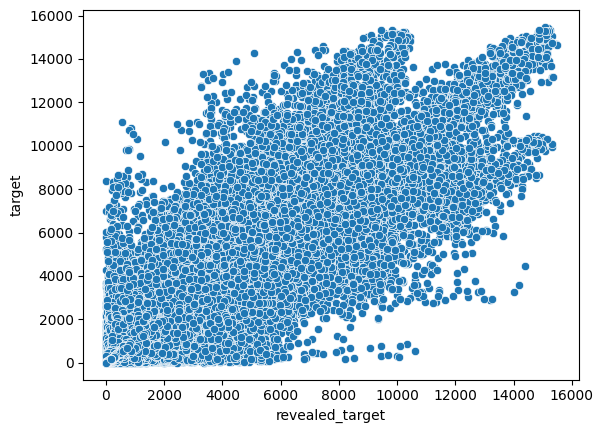

In [28]:
sns.scatterplot(train, x='revealed_target', y='target')

## TFT

In [29]:
!pip install -qqq lightning pytorch_forecasting --no-index --find-links=file:///kaggle/input/lightning-pytorch-forecasting-20231109/tft_need_module_20231109/

In [30]:
from pytorch_forecasting import TimeSeriesDataSet, Baseline, TemporalFusionTransformer
from pytorch_forecasting import GroupNormalizer

In [31]:
prediction_steps = 24
max_prediction_length = prediction_steps
max_encoder_length = 24 # Go back  60 Days 
training_cutoff = train["time_idx"].max() - max_prediction_length

In [32]:
categorical_columns_list = ["county", "is_business", "product_type", "is_consumption", "is_weekend_or_holiday",
                            "hour"  , "datetime_sin", "datetime_cos", 
                           ]
for col_name in categorical_columns_list:
    train[col_name] = train[col_name].astype(str).astype('category')

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2012496 entries, 0 to 2012495
Data columns (total 44 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   county                                  category      
 1   is_business                             category      
 2   product_type                            category      
 3   target                                  float64       
 4   is_consumption                          category      
 5   row_id                                  int64         
 6   new_datetime                            datetime64[ns]
 7   revealed_target                         float64       
 8   hour                                    category      
 9   eic_count                               float64       
 10  installed_capacity                      float64       
 11  gas_low_per_mwh                         float64       
 12  gas_high_per_mwh                        fl

In [34]:
train = train.reset_index()

In [35]:
365*24*2

17520

In [36]:
training_cutoff

15239

## split is_consumption

In [37]:
# train['is_consumption'] = train['is_consumption'].astype(int)
# train_0 = train.loc[train.is_consumption == 0,]

# Training TFT

## Setting for features

In [38]:

training = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx", ### 시간에 대한 index 우리 데이터는 1시간 단위로 시간 흐름을 int로 표현해야 함
    target="target", ### 목표 값
    group_ids=["is_business", "product_type", "county", 'is_consumption'], ### 우리 대회에서는 is_business, product_type, county (is_consumption은 해당사항 아님)
    ### max_encoder_lenght는 과거 몇 시간동안의 데이터를 사용할지 설정 int로 예 24
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    ### max_prediction_length는 미래의 알고 싶은 시간에 대한 길이를 입력하면 될듯...24시간.
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    ### 카테고리컬 통계 정보 설정
    
    static_categoricals=["county", # categorical type
                         "is_business", # categorical type
                         "product_type", # categorical type
#                          "is_consumption", # categorical type
                         "is_weekend_or_holiday", # categorical type
                        ], 
    static_reals=["installed_capacity",
                        "eic_count",
                 ],
    time_varying_known_categoricals=["hour", "datetime_sin", "datetime_cos"],
    time_varying_known_reals=["time_idx",
                              "fore_10_metre_u_wind_component",
                              'fore_10_metre_v_wind_component',
                              'fore_temperature',
                              "fore_dewpoint",
                              "fore_cloudcover_high",
                              "fore_cloudcover_low",
                              "fore_cloudcover_mid",
                              "fore_cloudcover_total",
                              "fore_direct_solar_radiation",
                              "fore_surface_solar_radiation_downwards",
                              "fore_snowfall",
                              "fore_total_precipitation",
                              
],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "target"
    ],
    target_normalizer=GroupNormalizer(
        groups=["is_business", "product_type", "county", 'is_consumption'], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
#     add_target_scales=False,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)


In [39]:
# training

In [40]:
# validation

# Batch

In [41]:
# create dataloaders for model
batch_size = 336  # set this between 32 to 128
batch_size = 168  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2, drop_last=False)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2, drop_last=False)

# Baseline

In [42]:
import torch

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


253.1487579345703

In [43]:
actuals.shape

torch.Size([138, 24])

In [44]:
baseline_predictions.shape

torch.Size([138, 24])

# Hyperparameter Optimization

In [45]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

use_optuna_tuning = False

# create study
if use_optuna_tuning:
    study = optimize_hyperparameters(
        train_dataloader,
        val_dataloader,
        model_path="optuna_test",
        n_trials=50,
        max_epochs=20,
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=(8, 64),
        hidden_continuous_size_range=(8, 64),
        attention_head_size_range=(1, 4),
        learning_rate_range=(0.001, 0.1),
        dropout_range=(0.1, 0.3),
    #     trainer_kwargs=dict(limit_train_batches=30, log_every_n_steps=15, gpus=1),
        trainer_kwargs=dict(limit_train_batches=30, log_every_n_steps=15),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
        timeout=4200
    )

    # show best hyperparameters
    print(study.best_trial.params)

# Apply hyper-parameter and Retrain TFT

In [46]:
# params = {'gradient_clip_val': 0.04236328089506517, 'hidden_size': 30, 
#           'dropout': 0.1850590365123, 'hidden_continuous_size': 8,
#           'attention_head_size': 3, 'learning_rate': 0.0592019319527603}

In [47]:
params = {'gradient_clip_val': 0.06926374996686949, 'hidden_size': 36,
 'dropout': 0.14143477075854113, 'hidden_continuous_size': 8,
 'attention_head_size': 4, 'learning_rate': 0.03612537124283431}

In [48]:
#Early Stopping 
MIN_DELTA  = 1e-4
PATIENCE = 10

#PL Trainer
# MAX_EPOCHS = 150
MAX_EPOCHS = 100
# GPUS = 1
GRADIENT_CLIP_VAL=params['gradient_clip_val'] # gradient_clip_val
LIMIT_TRAIN_BATCHES=30

#Fusion Transformer
LR = params['learning_rate']
HIDDEN_SIZE = params['hidden_size']
DROPOUT = params['dropout']
ATTENTION_HEAD_SIZE = params['attention_head_size']
HIDDEN_CONTINUOUS_SIZE = params['hidden_continuous_size']
OUTPUT_SIZE=7
REDUCE_ON_PLATEAU_PATIENCE=5

## Trainer

In [49]:
import lightning.pytorch as pl
# import pytorch_lightning as pl
from pytorch_forecasting.metrics import QuantileLoss
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor

from lightning.pytorch.loggers import TensorBoardLogger

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=MIN_DELTA, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS, # 20
#     gpus=GPUS,
#     weights_summary="top", ## default
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=GRADIENT_CLIP_VAL, ## params['gradient_clip_val']
    limit_train_batches=LIMIT_TRAIN_BATCHES,#oment in for training, running valiation every 30 batches ### 30 input
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger, ## 이게 왜 추가 되었을까?
    log_every_n_steps=10
)

In [50]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LR,
    hidden_size=HIDDEN_SIZE,
    attention_head_size=ATTENTION_HEAD_SIZE,
    dropout=DROPOUT,
    hidden_continuous_size=HIDDEN_CONTINUOUS_SIZE,
    output_size=OUTPUT_SIZE,# 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=REDUCE_ON_PLATEAU_PATIENCE,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 139.0k


In [51]:
import tensorflow as tf 
import tensorboard as tb 
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
tf.io.gfile = tf.compat.v1.io.gfile

In [52]:
# fit network
# import lightning.pytorch
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 26.6 K
3  | prescalers                         | ModuleDict                      | 320   
4  | static_variable_selection          | VariableSelectionNetwork        | 6.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 20.5 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 19.1 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 5.4 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 5.4 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [53]:
trainer.checkpoint_callback.best_model_path

'lightning_logs/lightning_logs/version_0/checkpoints/epoch=99-step=3000.ckpt'

In [54]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [55]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(60.4709)

In [56]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [57]:
len(raw_predictions)

5

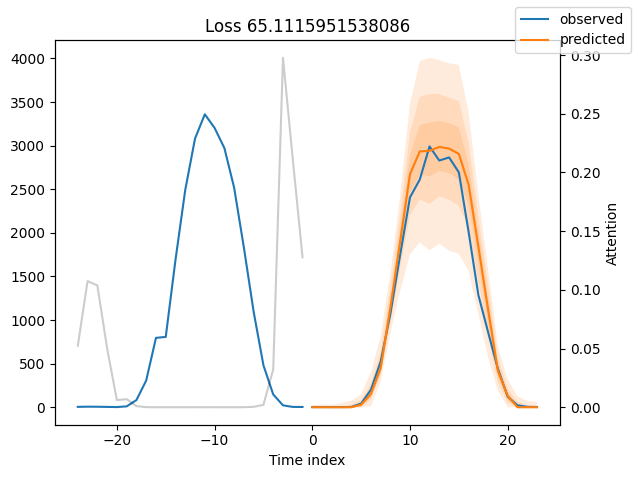

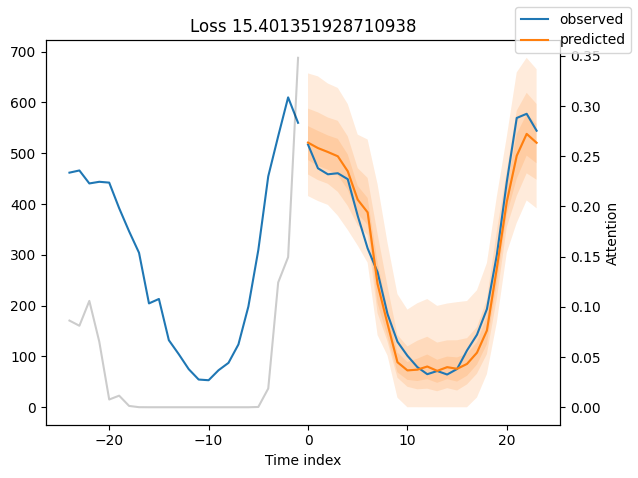

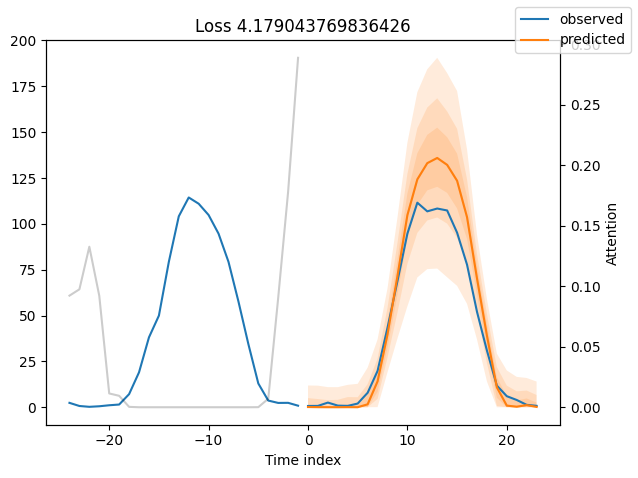

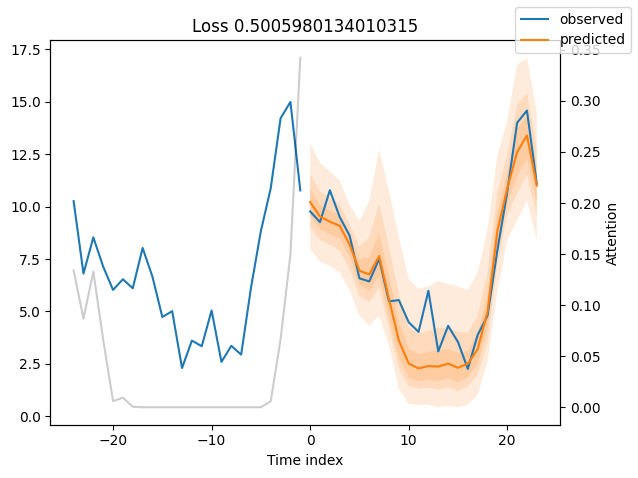

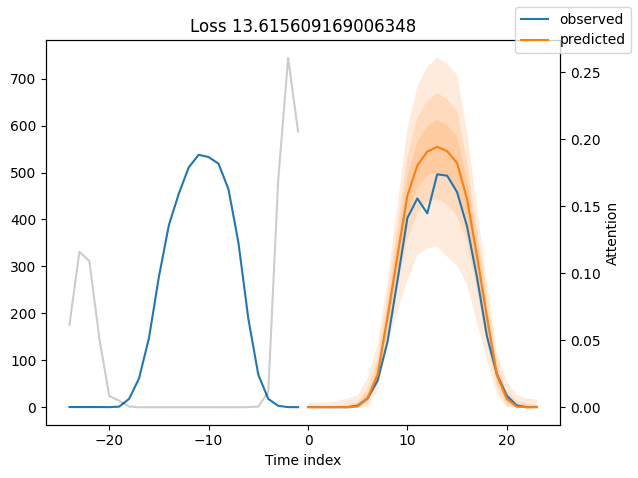

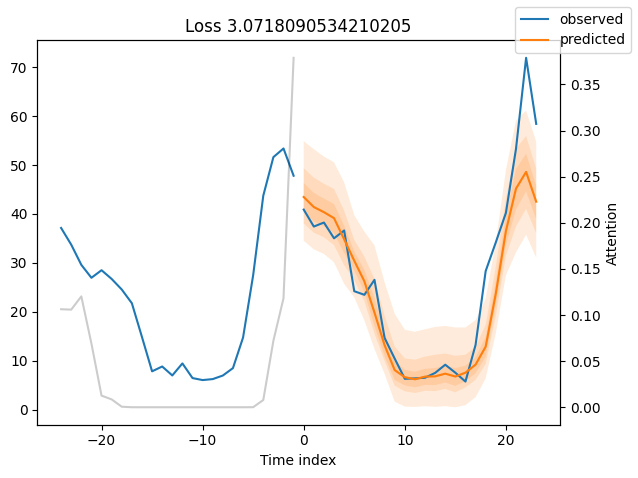

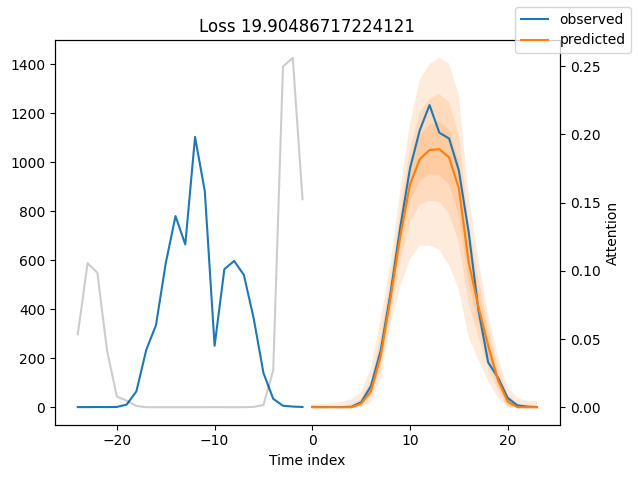

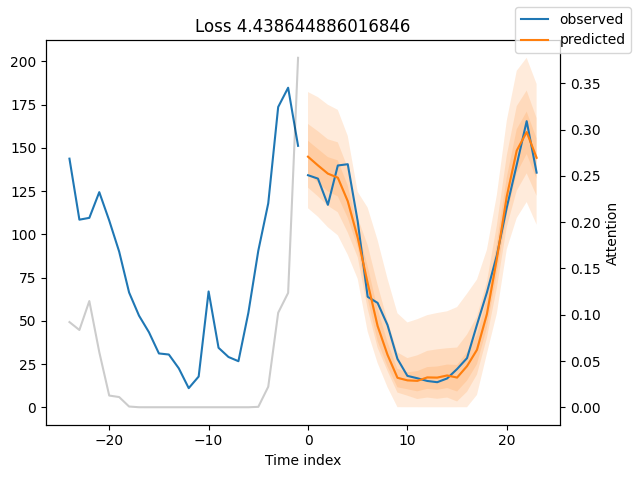

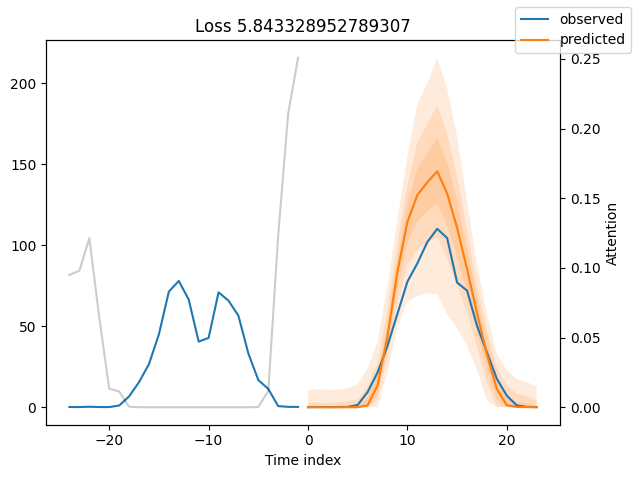

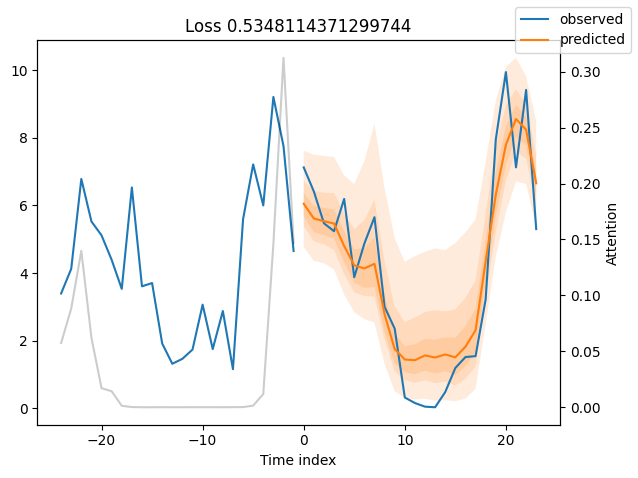

In [58]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, show_future_observed=True, add_loss_to_title=True)

# Variable importances

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x425 with 1 Axes>,
 'encoder_variables': <Figure size 700x650 with 1 Axes>,
 'decoder_variables': <Figure size 700x625 with 1 Axes>}

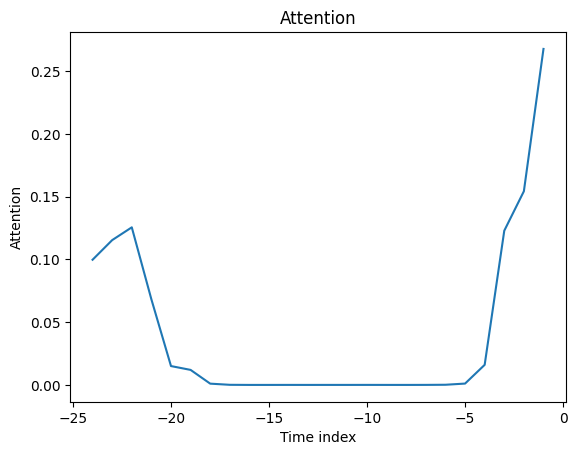

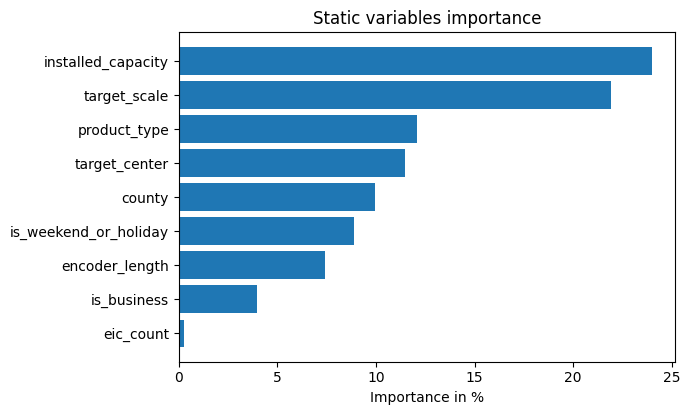

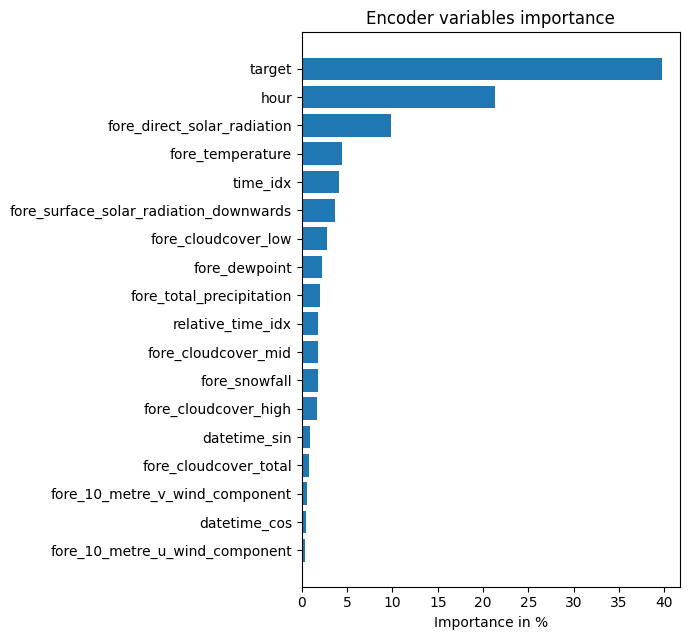

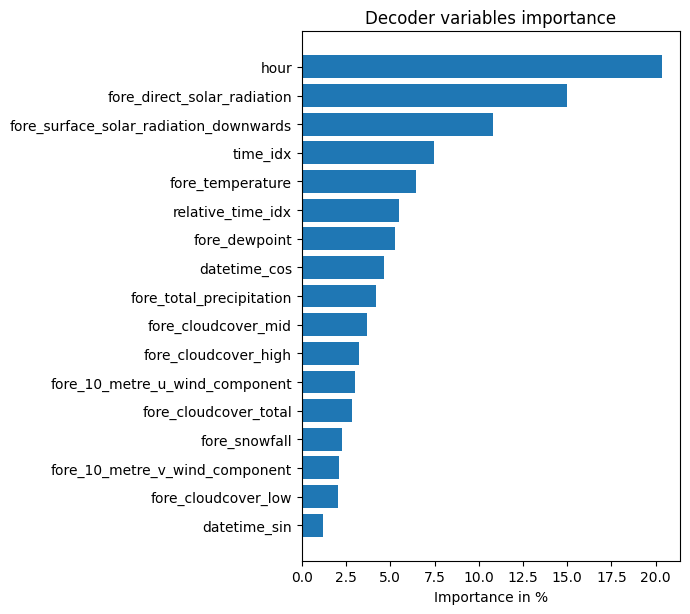

In [59]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

# Check output value

In [60]:
predictions = best_tft.predict(val_dataloader, mode="prediction", return_x=False)

In [61]:
pd.DataFrame(predictions.numpy()).T

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,9.998843e-26,520.812500,0.121663,10.210671,0.000157,43.462456,3.741863e-08,144.825180,0.009728,6.048608,...,4.291987e-21,1300.739746,8.356796e-12,89.830864,7.304940e-10,653.857422,7.771628e-08,434.022705,0.000222,199.089386
1,3.449491e-25,510.050415,0.052360,9.521972,0.000110,41.410324,2.700824e-08,139.792679,0.005960,5.614839,...,1.913500e-21,1288.177490,2.153024e-13,89.476768,3.176440e-09,642.381470,3.737583e-08,433.526428,0.000091,193.774506
2,2.577171e-25,502.313629,0.027319,9.278151,0.000098,40.360153,1.035509e-08,135.036469,0.003753,5.533264,...,1.178528e-20,1285.359741,1.161992e-13,89.729347,3.492018e-09,640.000916,7.286380e-09,432.896179,0.000055,192.941650
3,2.232278e-18,493.878754,0.019734,9.079823,0.001073,39.138153,8.288876e-06,132.708511,0.003915,5.465197,...,5.427293e-15,1282.622070,8.612527e-14,91.106491,1.862659e-06,635.414307,1.560377e-06,439.457733,0.001009,191.636734
4,4.754596e-09,464.342194,0.055483,8.194960,0.007024,34.818966,7.237668e-03,119.103287,0.005981,4.801371,...,1.200799e-06,1308.246582,6.609657e-13,100.866592,1.234237e-01,630.145874,1.768380e-03,458.820190,0.096407,193.041260
5,2.979778e+01,408.489410,0.022391,6.942347,1.668455,30.434425,1.530711e+01,98.028358,0.003731,4.230496,...,3.879794e+01,1290.376587,7.557907e-07,126.754219,2.235751e+01,634.451599,1.894523e+01,450.831512,12.142876,194.373810
6,1.518526e+02,383.512695,1.592478,6.765479,19.999397,26.232010,6.545759e+01,71.840958,1.230090,4.138287,...,1.173769e+02,1239.850220,2.910572e-02,176.037170,7.854253e+01,701.281006,8.395386e+01,439.160461,51.491337,213.032227
7,4.495420e+02,242.377747,14.147904,7.643916,69.333313,19.842550,2.100123e+02,47.023643,13.525296,4.273491,...,3.256877e+02,1091.603149,7.412102e+00,215.854370,2.144858e+02,743.590149,2.458265e+02,388.072784,171.747833,246.070374
8,1.148155e+03,164.263580,39.701839,5.597552,191.791031,13.171574,4.448519e+02,30.318718,43.918217,2.782885,...,8.521919e+02,935.896545,3.506671e+01,227.394592,5.539506e+02,747.411865,5.653209e+02,331.478516,346.609497,256.714081
9,1.906417e+03,88.681274,71.567680,3.616287,322.993958,8.075390,6.983328e+02,17.031319,83.694275,1.754138,...,1.416872e+03,597.290833,7.123727e+01,189.070923,8.845865e+02,692.329773,8.712070e+02,273.679138,497.146393,224.077927


# another method for fit

In [62]:
# # configure network and trainer
# from lightning.pytorch.loggers import TensorBoardLogger

# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
# lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

# trainer = pl.Trainer(
#     max_epochs=50,
#     accelerator="cpu",
#     enable_model_summary=True,
#     gradient_clip_val=0.1,
#     limit_train_batches=50,  # coment in for training, running valiation every 30 batches
#     # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
#     callbacks=[lr_logger, early_stop_callback],
#     logger=logger, ## 이게 왜 추가 되었을까?
# )

# # tft = TemporalFusionTransformer.from_dataset(
# #     training,
# #     learning_rate=0.03,
# #     hidden_size=16,
# #     attention_head_size=2,
# #     dropout=0.1,
# #     hidden_continuous_size=8,
# #     loss=QuantileLoss(),
# #     log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
# #     optimizer="Ranger",
# #     reduce_on_plateau_patience=4,
# # )
# # print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=LR,
#     hidden_size=HIDDEN_SIZE,
#     attention_head_size=ATTENTION_HEAD_SIZE,
#     dropout=DROPOUT,
#     hidden_continuous_size=HIDDEN_CONTINUOUS_SIZE,
#     output_size=OUTPUT_SIZE,# 7 quantiles by default
#     loss=QuantileLoss(),
#     log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
#     reduce_on_plateau_patience=REDUCE_ON_PLATEAU_PATIENCE,
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [63]:
# # fit network
# trainer.fit(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
# )

In [64]:
# pd.DataFrame(temp_1.numpy()).T - pd.DataFrame(predictions.numpy()).T

# Submit

In [65]:
# prepare input
def prepare_input_for_real_data(tr, clie, gas, elec, fore, hist):

    
    # change column names
    clie=clie.rename(columns={'date':'origin_date'})
    elec=elec.rename(columns={'euros_per_mwh':'electricity_euros_per_mwh'})
    gas=gas.rename(columns={'lowest_price_per_mwh':'gas_low_per_mwh','highest_price_per_mwh':'gas_high_per_mwh'})
    
    # make 'hour' column
    tr['hour']=pd.to_datetime(tr.datetime).dt.hour
    # make 'date' column synced with 'date' in train
    tr['date']=pd.to_datetime(tr.datetime).dt.strftime('%Y-%m-%d')
    clie['date']=clie.origin_date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d')+timedelta(days=2)).dt.strftime('%Y-%m-%d')
    gas['date']=gas.forecast_date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d')+timedelta(days=1)).dt.strftime('%Y-%m-%d')
    fore['date']=fore.origin_datetime.apply(lambda x:datetime.strptime(x.split('+')[0],'%Y-%m-%d %H:%M:%S')+timedelta(days=1)).dt.strftime('%Y-%m-%d')
    # make 'datetime' column synced with 'datetime' in train
    elec['datetime']=elec.forecast_date.apply(lambda x:str(datetime.strptime(x,'%Y-%m-%d %H:%M:%S')+timedelta(days=1)))
    fore=fore.rename(columns={'forecast_datetime':'datetime'})
    fore['datetime']=fore.datetime.str.split('+').str[0] 
    
    # replace outliers in electricity_prices with .interpolate()
    condition=(abs(elec.electricity_euros_per_mwh-elec.electricity_euros_per_mwh.shift(1)) > 1000)&(abs(elec.electricity_euros_per_mwh-elec.electricity_euros_per_mwh.shift(-1)) > 1000) 
    elec['electricity_euros_per_mwh']=np.where(condition, np.NaN, elec.electricity_euros_per_mwh)
    elec['electricity_euros_per_mwh']=elec.electricity_euros_per_mwh.interpolate()
    # fill NaN at 3am in target
#     tr['target']=tr.groupby(['is_consumption','prediction_unit_id']).target.apply(lambda x : x.interpolate()).reset_index().set_index('level_2').drop(columns=['is_consumption','prediction_unit_id'])
 
    # 1. make revealed target column
#     tr['revealed_target']=tr.groupby(['is_consumption','prediction_unit_id']).target.shift(48)
#     tr['revealed_target']
    
    # 2. merge with client
    tr=pd.merge(tr,clie.drop(columns=['origin_date']),on=['product_type', 'county', 'is_business','date'], how='left')
    tr['eic_count']=tr.eic_count.fillna(0)
    tr['installed_capacity']=tr.installed_capacity.fillna(0)
 
    # 3. merge with gas_prices
    tr=pd.merge(tr, gas.drop(columns=['forecast_date','origin_date']), on=['date'], how='left')

    # 4. merge with electricity_prices
    tr=pd.merge(tr, elec.drop(columns=['forecast_date','origin_date']), on=['datetime'], how='left')
    # fill NaN at 2am in electicity 
    tr['electricity_euros_per_mwh']=tr.groupby(['is_consumption','prediction_unit_id']).electricity_euros_per_mwh.apply(lambda x : x.interpolate()).reset_index().set_index('level_2').drop(columns=['is_consumption','prediction_unit_id'])

    # 5. merge with forecast info    
    # change column names
    fore_col=['10_metre_u_wind_component', '10_metre_v_wind_component','temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low',
               'cloudcover_mid', 'cloudcover_total', 'direct_solar_radiation','surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
    for col in fore_col: 
        fore=fore.rename(columns={col:'fore_'+col})
    # merge
    tr=pd.merge(tr,fore.drop(columns=['origin_datetime', 'hours_ahead']),on=['county','datetime','date'], how='left')
    
    
    # 6. merge with historical info
    hist['train_datetime']=hist.datetime.apply(lambda x:str(datetime.strptime(x,'%Y-%m-%d %H:%M:%S')+timedelta(hours=37))) #make train_datetime column
    # change column names
    hist_col=['temperature', 'dewpoint', 'rain', 'snowfall','surface_pressure', 'cloudcover_total', 'cloudcover_low','cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
               'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation','diffuse_radiation']
    for col in hist_col: 
        hist=hist.rename(columns={col:'bef_37h_'+col}) 
    # drop real datetime
    hist=hist.drop(columns=['datetime'])
    # merge
    tr=pd.merge(tr,hist.rename(columns={'train_datetime':'datetime'}),on=['county','datetime'], how='left')
    
    # convert datetime to sin/cos
    tr['datetime_sin'] = np.sin(pd.to_datetime(tr.datetime).dt.dayofyear/366)
    tr['datetime_cos'] = np.cos(pd.to_datetime(tr.datetime).dt.dayofyear/366)
    
    # insert holiday info 
    tr['is_weekend_or_holiday']=np.where((pd.to_datetime(tr.datetime).dt.weekday==5)|(pd.to_datetime(tr.datetime).dt.weekday==6),1,0) # weekend
    fixed_holiday_list=['01-01','02-24','05-01','06-23','06-24','08-20','12-24','12-25','12-26']                                      # public holiday(Easter Sunday, Pentecost, (Good Friday) 빠짐)
    for day in fixed_holiday_list:
        tr['is_weekend_or_holiday']=np.where(pd.to_datetime(tr.date).dt.strftime('%m-%d')==day,1,tr['is_weekend_or_holiday'])
    
    # drop unnecessary columns
    tr=tr.drop(columns=['datetime','prediction_unit_id', 'date'])
    
    return tr

In [66]:
def checking_is_datetime(df):
    """
    날짜형 타입을 문자열로 변경해주는 함수입니다. 모든 컬럼마다 확인하고 str로 반환합니다.
    check the type of datetime
    if datetime64, --> str
    """
    for column in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[column]):
            df[column] = df[column].astype(str)

In [67]:
def shift_day(df, df_datetime_name, delta_day):
    """
    shift day
    날짜를 입력한(delta_day)만큼 이동합니다.
    ex) 2010-01-01 00:00:00 --> 2010-01-02 00:00:00 if shift_day(df, "datetime", 1)
    """
    df[df_datetime_name] = df[df_datetime_name] + pd.Timedelta(days=delta_day)

In [68]:
import enefit
env = enefit.make_env()
iter_test = env.iter_test()

debug = False

# Reload enefit environment (only in debug mode, otherwise the submission will fail)
if debug :
    enefit.make_env.__called__ = False
    type(env)._state = type(type(env)._state).__dict__['INIT']
    iter_test = env.iter_test()
# env = enefit.make_env()
# iter_test = env.iter_test()

In [69]:
count = 0
for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
#     break
    test = test.rename(columns={'prediction_datetime':'datetime'})
    test['new_datetime'] = test['datetime']

    shift_day(revealed_targets, "datetime", 2)
    # shift_day(client, "date", 2)
#     shift_day(historical_weather, 'datetime', 2)
#     shift_day(forecast_weather, "origin_datetime", 1)
    # shift_day(electricity_prices, 'origin_date', 2)
    # shift_day(gas_prices, 'origin_date', 2)

    test['revealed_target'] = pd.merge(test, revealed_targets, on=['is_consumption', 'county', 'is_business', 'product_type', 'datetime'], how='left').target.values

    # change from datetime64 to str
    check_list = [test, revealed_targets, client, historical_weather, forecast_weather, electricity_prices, gas_prices]
    for df_ in check_list:
        checking_is_datetime(df_)

    fore_info, hist_info = make_weather_info(counties_info, forecast_weather, historical_weather)
    test['target'] = 0
    temp_0 = prepare_input(test, client, gas_prices, electricity_prices, fore_info, hist_info)
#     temp_0 = prepare_input_for_real_data(test, client, gas_prices, electricity_prices, fore_info, hist_info)
    temp_0['is_business'] = temp_0.is_business.map({False:0, True:1})
    temp_0['is_consumption'] = temp_0.is_consumption.map({False:0, True:1})
    
    temp_0['new_datetime'] = pd.to_datetime(temp_0['new_datetime'])
    temp_0['time_idx'] = ((temp_0['new_datetime'] - train['new_datetime'].min()).dt.total_seconds() / 3600).astype(int)
    
    categorical_columns_list = ["county", "is_business", "product_type", "is_consumption", "is_weekend_or_holiday",
                            "hour"  , "datetime_sin", "datetime_cos", 
                           ]
    for col_name in categorical_columns_list:
        temp_0[col_name] = temp_0[col_name].astype(str).astype('category')
    
    temp_0 = temp_0.drop(columns = 'new_datetime')

    categorical_columns_list = ["county", "is_business", "product_type", "is_consumption", "is_weekend_or_holiday",
                            "hour"  , "datetime_sin", "datetime_cos", 
                           ]
    for col_name in categorical_columns_list:
        temp_0[col_name] = temp_0[col_name].astype(str).astype('category')

    for col_name in temp_0.columns:
        if col_name not in categorical_columns_list:
            temp_0[col_name] = temp_0[col_name].astype(float)
    
    temp_0['time_idx'] = temp_0['time_idx'].astype(int)
    temp_1 = temp_0.copy()
    temp_1['time_idx'] = temp_0['time_idx'] + 24
    temp_1['time_idx'] = temp_1['time_idx'].astype(int)
    
    com_data = pd.concat([temp_0, temp_1], ignore_index=True)
    
    prediction_data = best_tft.predict(com_data, mode="prediction", return_x=False)
    
    prediction_data = pd.DataFrame(prediction_data.numpy()).T
#     prediction_data.value
    sample_prediction['target'] = prediction_data.values.ravel()

#     count += 1
#     if count == 1:
#         break
    
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector